In [1]:
import yfinance as yf
import pandas as pd
import os


In [2]:
# Load data
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
# Ensure the index is in datetime format and remove unused cols
sp500.index = pd.to_datetime(sp500.index, utc=True)
del sp500["Dividends"]
del sp500["Stock Splits"]


In [4]:
sp500

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2024-12-02 05:00:00+00:00,6040.109863,6053.580078,6035.330078,6047.149902,4412470000
2024-12-03 05:00:00+00:00,6042.970215,6052.069824,6033.390137,6049.879883,4095000000
2024-12-04 05:00:00+00:00,6069.390137,6089.839844,6061.060059,6086.490234,4003390000


<Axes: xlabel='Date'>

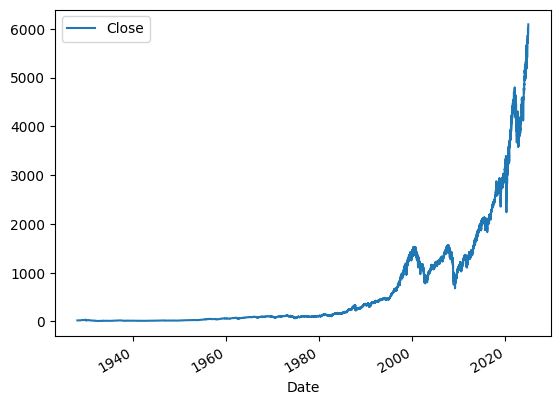

In [5]:
sp500.plot.line(y="Close", use_index=True)

In [6]:
#add tomorrow col labled 1 for increase 0 for otherwise
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2024-12-02 05:00:00+00:00,6040.109863,6053.580078,6035.330078,6047.149902,4412470000,6049.879883,1
2024-12-03 05:00:00+00:00,6042.970215,6052.069824,6033.390137,6049.879883,4095000000,6086.490234,1
2024-12-04 05:00:00+00:00,6069.390137,6089.839844,6061.060059,6086.490234,4003390000,6075.109863,0


In [7]:
# Filter for dates after 1990 for relevance
sp500 = sp500.loc["1990-01-01":].copy() 




In [8]:
from sklearn.ensemble import RandomForestClassifier
#random forest classifier
# trains individual descision trees with randomized parameters and averages the results 
# resistant to overfitting
# run quickly 
# can find non-linear relationships/correlations like for open price vs target`

#initialize model with parameters
# n_estimators # decision trees - higher may be better up to a limit
# min_samples_split - protects against overfitting by not going to deeply when making trees the higher this val the less accurate the model, but the less overfit
# random_state - the seed for the model to keep generated vals consistent
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# don't use cross validation by being aware of the future by taking train from the past and test from the future
#TODO use test train split but time aware
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

#use cols that are not vals we are predicting for predictors
# target or tomorrow are unknowns and shouldn't be added here
predictors = ["Close", "Volume", "Open", "High", "Low"] 
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [9]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

np.float64(0.5858585858585859)

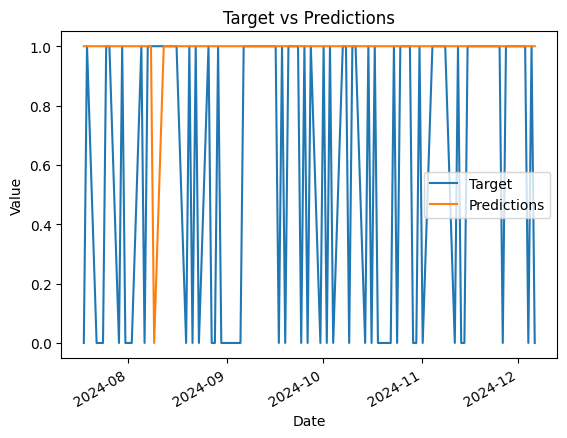

In [10]:
import matplotlib.pyplot as plt

combined = pd.concat([test["Target"], preds], axis=1)
combined.columns = ["Target", "Predictions"] 
combined.plot()
# Rename the columns 

#Plot with labels 
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Target vs Predictions") 
plt.show()

In [11]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
#1 year 250 approx tradings days
#take  1o years at a time (start) and predict the next year's data (step) then use that data to predict the next year
#creating the test set of current year and train set of all the previous years
#TODO add analysis here 20 mins in

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [13]:
predictions = backtest(sp500, model, predictors)

In [14]:
predictions["Predictions"].value_counts()

Predictions
0    3676
1    2625
Name: count, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5291428571428571)

In [16]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536423
0    0.463577
Name: count, dtype: float64

In [ ]:
#add rolling average predictors - time series

horizons = [2,5,60,250,1000] #in days
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    sp500.rolling(horizon)
    
    new_predictors+= [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"]) #resolve not enough days available NaN rows

In [19]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 05:00:00+00:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 05:00:00+00:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 05:00:00+00:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 05:00:00+00:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 05:00:00+00:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02 05:00:00+00:00,6040.109863,6053.580078,6035.330078,6047.149902,4412470000,6049.879883,1,1.001223,2.0,1.004935,4.0,1.041615,39.0,1.134746,148.0,1.349865,531.0
2024-12-03 05:00:00+00:00,6042.970215,6052.069824,6033.390137,6049.879883,4095000000,6086.490234,1,1.000226,2.0,1.003304,4.0,1.040356,39.0,1.133996,149.0,1.349757,532.0
2024-12-04 05:00:00+00:00,6069.390137,6089.839844,6061.060059,6086.490234,4003390000,6075.109863,0,1.003017,2.0,1.007209,4.0,1.044882,39.0,1.139545,150.0,1.357191,533.0


In [ ]:
#update to improve accuracy
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] #probability stock goes up tomorrow
    preds[preds >=.6] = 1 #set at .6 to make the model have to be more confident
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
#use only the new predictors as the ratios are more informative to the model rather than raw values. 
predictions = backtest(sp500, model, new_predictors)

In [ ]:
#todo add analysis here
predictions["Predictions"].value_counts()

Predictions
0.0    4450
1.0     851
Name: count, dtype: int64

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5757931844888367)

In [25]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.546123
0    0.453877
Name: count, dtype: float64

In [26]:
predictions

,Target,Predictions
Date,,
2003-11-14 05:00:00+00:00,0,0.0
2003-11-17 05:00:00+00:00,0,1.0
2003-11-18 05:00:00+00:00,1,1.0
2003-11-19 05:00:00+00:00,0,0.0
2003-11-20 05:00:00+00:00,1,1.0
...,...,...
2024-12-02 05:00:00+00:00,1,0.0
2024-12-03 05:00:00+00:00,1,0.0
2024-12-04 05:00:00+00:00,0,0.0


Summary:
loaded data
cleaned and visualized data
set up machine learning target
trained initial model
evaluated error found a way to backtest to evaluate error over time
improved model with additional predictors

Next steps:
add news and congress person purchases
analyze key stocks and key sectors for those trades 
use one congress person with multiple trades
use multiple congress persons any number of trades of a stock

congress person, buys stock, day, time
